<a href="https://colab.research.google.com/github/ykitaguchi77/CongenitalGlaucoma_AI_project/blob/main/Periocular_annotations_for_YOLOv5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Periocular_annotations_for_YOLOv5**

In [1]:
import pandas as pd
import os
import glob
import shutil
import glob
import random
from PIL import Image
import time
%matplotlib inline

#サポートパッチのインポート
from google.colab.patches import cv2_imshow
import cv2


# Google Driveをマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

# 患者のリスト(緑内障のみ)
csv_path = "/content/drive/MyDrive/Deep_learning/Congenital_Glaucoma/extended_dataset_for_YOLOv5/patient_data.csv"

df = pd.read_csv(csv_path, index_col= 0)
df

,id,R,L
0,1546,0,1
1,1962,1,1
2,2004,1,0
3,2223,1,0
4,2761,0,1
5,3229,1,0
6,3422,1,1
7,379,1,1
8,4377,1,0
9,4407,1,0


In [ ]:
# glaucoma_extended datasetをcolab上に解凍する
!cp "/content/drive/MyDrive/Deep_learning/Congenital_Glaucoma/glaucoma_extended_dataset.zip" .
!unzip glaucoma_extended_dataset.zip



In [ ]:
#glaucoma患者のリストを作成
image_dir = "/content/drive/MyDrive/Deep_learning/Congenital_Glaucoma/dataset_for_YOLO_1280px"


gla_folder = ["gla_eso", "gla_exo", "gla_ortho"]

patient_id_list = []
for folder in gla_folder:
    file_list = [os.path.basename(i).split('-')[0].split('_')[0] for i in glob.glob(f"{image_dir}/{folder}/*")]
    patient_id_list.extend(file_list)

patient_id_list = sorted(list(set(patient_id_list)))
print(patient_id_list)
len(patient_id_list)


['1546', '1962', '2004', '2223', '2761', '3229', '3422', '379', '4377', '4407', '4725', '4849', '5393', '5617', '5821', '6668', '6821', '6895', '713', '7154', '7495', '781', '8126', '8128', '8193', '8246', '8294', '8425', '8492', '8500', '8698', '8882', '8921', '9056', '9201']


35

In [ ]:
df_patient_data = pd.DataFrame(index=[], columns=[])
df_patient_data["id"] = patient_id_list
df_patient_data

In [ ]:
#patient_idの入った空のリストをセーブ

new_dir = "/content/drive/MyDrive/Deep_learning/Congenital_Glaucoma/extended_dataset_for_YOLOv5"
if os.path.exists(new_dir):
    shutil.rmtree(new_dir)
os.makedirs(new_dir)

df_patient_data.to_csv(f"{new_dir}/patient_data_vacant.csv")


idの横にRとLの列を作成

混濁していたら1を記入

patient_data.csvとして保存

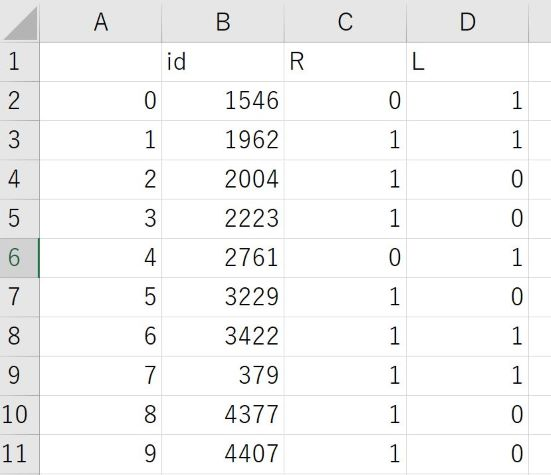

In [ ]:
import pandas as pd

csv_path = "/content/drive/MyDrive/Deep_learning/Congenital_Glaucoma/extended_dataset_for_YOLOv5/patient_data.csv"

df = pd.read_csv(csv_path, index_col= 0)
df



#**Extract periocular images and annotate with dataframe**

## Haarcascadeを指定

In [39]:
# カスケードファイルのパス
eye_cascade_path = '/content/drive/My Drive/Deep_learning/haarcascade_eye.xml'
# righteye_cascade_path = '/content/drive/My Drive/Deep_learning/haarcascade_righteye_2splits.xml'
# lefteye_cascade_path = '/content/drive/My Drive/Deep_learning/haarcascade_lefteye_2splits.xml'


# カスケード分類器の特徴量取得
eye_cascade = cv2.CascadeClassifier(eye_cascade_path)
# righteye_cascade = cv2.CascadeClassifier(eye_cascade_path)
# lefteye_cascade = cv2.CascadeClassifier(eye_cascade_path)

## 眼周囲切り抜き

class_num = 4



0: 右眼、濁りなし

1: 右眼、濁りあり

2: 左眼、濁りなし

3: 左眼、濁りあり

In [40]:
#アスペクト比を維持したまま横を400pixelに縮小する
def scale_to_width(img, width):
    scale = width / img.shape[1]
    return cv2.resize(img, dsize=None, fx=scale, fy=scale)

#図を表示する
def show_image(img):
    #img = cv2.imread(out_path)
    dst = scale_to_width(img, 200)
    cv2_imshow(dst)

# def show_image_pillow(img):
#     src = cv2.cvtColor(img_resized_list[0], cv2.COLOR_BGR2RGB)
#     plt.imshow(src)

def my_round(val, digit=0):
    p = 10 ** digit
    return int((val * p * 2 + 1) // 2 / p)

def scale_to_width(img, width):
    """幅が指定した値になるように、アスペクト比を固定して、リサイズする。
    """
    h, w = img.shape[:2]
    height = round(h * (width / w))
    dst = cv2.resize(img, dsize=(width, height))

    return dst

In [ ]:
orig_folder = "/content/dataset_extended"
dst_folder = "/content/drive/MyDrive/Deep_learning/Congenital_Glaucoma/extended_dataset_for_YOLOv5/images"
if os.path.exists(dst_folder):
    shutil.rmtree(dst_folder)
os.makedirs(dst_folder)


path_list = glob.glob(orig_folder+"/*")
#path_list = [path_list[1]] #テスト用
#path_list = path_list[1:100] #テスト用
#path_list = ["/content/dataset_extended/9201-20210304-0-113733_2fa4e6a541d752afc0c740c856f0fbce9a435341353847cb60b6732b055989df.jpg"]


dst_folder = dst_folder

#処理時間の計測
start = time.time()

#もしdst_folderがあれば削除して新しく作り直す
if os.path.exists(dst_folder):
    shutil.rmtree(dst_folder)
os.makedirs(f"{dst_folder}/images") #image格納用
os.makedirs(f"{dst_folder}/images_cropped") #cropped_image格納用 (YOLOでは使用しない)
os.makedirs(f"{dst_folder}/labels") #label格納用


num=0
showImage = True
for path in path_list:
    try: #目が検出されなかった場合のエラー回避。片目ずつ抜き出して保存
        img2 = cv2.imread(path).copy()

        img_resized_list,side_list = [],[]

        img = cv2.imread(path) 
        img2 = img.copy()

        if showImage:
            show_image(img)

        # 画像グレースケール化
        grayscale_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        #300pix以上のもので目に見えるものを抽出
        eye_list = eye_cascade.detectMultiScale(grayscale_img, minSize=(300, 300))
        print("")
        print('image path = ', path)

        # 眼検出判定
        if len(eye_list) >= 1:
            print('目が' + str(len(eye_list)) +'個検出されました')
            pass
        else:
            print("no eye detected")
            pass

        print(f"eye_list: {eye_list}")

        #画像の切り抜きと保存（連番にする）
        if len(eye_list)== 2: 

            ex1, ey1, ew1, eh1 = eye_list[0]
            ex2, ey2, ew2, eh2 = eye_list[1]


            print(f"ex1: {ex1}, ex2: {ex2}, img2.shape: {img2.shape}")

            # 両眼がセンターラインを挟んで左右にあることを確認
            if (ex1+ew1/2 < img2.shape[1] / 2 and ex2+ew2/2 < img2.shape[1] / 2) or (ex1+ew1/2 > img2.shape[1] / 2 and ex2+ew2/2 > img2.shape[1] / 2):
                raise ValueError("The eyes must be on opposite sides of the face")
            

            
            
            for (ex, ey, ew, eh) in eye_list:
                print("[ex,ey] = %d,%d [ew,eh] = %d,%d" %(ex, ey, ew, eh))
 
                cv2.rectangle(img2, (ex, ey), (ex + ew, ey + eh), (0, 255, 0), 2)

                #切り抜き範囲が元画像をはみ出る場合は黒画像で埋める
                top = max(0, int(ey))
                bottom = min(grayscale_img.shape[0], int(ey + eh))
                left = max(0, int(ex))
                right = min(grayscale_img.shape[1], int(ex + ew))

                #print(f"top:{top}, bottom:{bottom}, left:{left}, right:{right}")

                img_cropped = img[top: bottom,left:right]
                height, width = img_cropped.shape[:2]

                #クロップした画像を表示
                if showImage:
                    show_image(img_cropped)


                #右か左かの判定
                if left >= img.shape[1]/2:
                    laterality = "L"
                elif right <= img.shape[1]/2:
                    laterality = "R"
                print(laterality)

                #混濁の有無（dfより抽出）
                id = os.path.basename(path).split("-")[0]

                if (df['id'] == int(id)).any(): #glaのリストに含まれているかどうか
                    if laterality == "R":
                        if df.loc[df['id'] == int(id), "R"].values[0] == 0:
                            class_num = 0 #右眼かつ混濁なし
                        elif df.loc[df['id'] == int(id), "R"].values[0] == 1:
                            class_num = 1 #右眼かつ混濁あり
                    elif laterality == "L":
                        if df.loc[df['id'] == int(id), "L"].values[0] == 0:
                            class_num = 2 #左眼かつ混濁なし
                        elif df.loc[df['id'] == int(id), "L"].values[0] == 1:
                            class_num = 3 #左眼かつ混濁あり

                elif not (df['id'] == int(id)).any(): #glaのリストに含まれていない場合
                    if laterality == "R":
                        class_num = 0 #右眼かつ混濁なし
                    elif laterality == "L":
                        class_num = 2 #左眼かつ混濁なし

                print(f"class_num: {class_num}")

                #縦、横に対する割合
                X = round((right+left)/2/img2.shape[1], 6)
                Y = round((top+bottom)/2/img2.shape[0], 6)
                W = round((right-left)/img.shape[1], 6)
                H = round((bottom-top)/img.shape[0], 6)
                txt = f"{class_num} {X} {Y} {W} {H}"

                img2 = scale_to_width(img2, 640)  #切り抜く前の画像を横のサイズを640になるように縮小
                cv2.imwrite(f"{dst_folder}/images/{os.path.basename(path).split('.')[0]}.JPG", img) #cropせずに縮小したイメージを保存
                cv2.imwrite(f"{dst_folder}/images_cropped/{os.path.basename(path).split('.')[0]}_{laterality}.JPG", img_cropped) #cropしたイメージを保存する場合

                with open(f"{dst_folder}/labels/{os.path.basename(path).split('.')[0]}.txt", mode='a') as f:
                    f.write(f"{txt}\n")
                num+=1
    except:
        pass

print("")
print('Process done!!')
elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")
print (f"image_num:{num}")

#**画像の選別**

・images_pathとimages_cropped_pathから不適切な画像を削除（眼の切り取り範囲がおかしい、眼鏡をかけているなど）

・imaes_pathに画像がある、images_cropped_pathに画像が2つ（RとL）ある、label_pathのtxtが2行（RとL)の全てを満たすもののみを残して
、あとは削除する（※バックアップのため、元フォルダを_backupに改名）

In [ ]:
import os
import shutil
import tqdm

patient_dir = "/content/drive/MyDrive/Deep_learning/Congenital_Glaucoma/extended_dataset_for_YOLOv5/images"
orig_label_dir = f"{patient_dir}/labels"
orig_images_cropped_dir = f"{patient_dir}/images_cropped"
orig_images_dir = f"{patient_dir}/images"
dst_label_dir = f"{patient_dir}/labels_selected"
dst_images_cropped_dir = f"{patient_dir}/images_cropped_selected"
dst_images_dir = f"{patient_dir}/images_selected"

# Create destination folders
for dir in [dst_label_dir, dst_images_cropped_dir, dst_images_dir]:
    if os.path.exists(dir):
        shutil.rmtree(dir)
    os.makedirs(dir)


# images_pathの画像リスト
images_list = glob.glob(f"{orig_images_dir}/*")
images_name_list = [os.path.splitext(os.path.basename(path))[0] in path for images_list]

# images_cropped_pathの画像リスト
images_cropped_list = glob.glob(f"{orig_images_cropped_dir}/*")
print(images_cropped_list)

# Labelのリスト
label_list = glob.glob(f"{orig_label_dir}/*")


for file in tqdm(images_name_list): #images_listの画像に対して
    if f"{orig_images_cropped_dir}/{file}_R.JPG" in images_cropped_list: #Rがあるかをチェック
        if f"{orig_images_cropped_dir}/{file}_L.JPG" in images_cropped_list: #Lがあるかをチェック
            if f"{orig_label_dir}/{file}.txt" in label_list:
                with open(f"{orig_label_dir}/{file}.txt", 'r') as f:
                    lines = f.readlines()
                    if len(lines) == 2:
                          shutil.copy(f"{orig_images_cropped_dir}/{file}_R.JPG", dst_images_cropped_dir)
                          shutil.copy(f"{orig_images_cropped_dir}/{file}_L.JPG", dst_images_cropped_dir)
                          shutil.copy(file, dst_images_dir)
                          shutil.copy(f"{orig_label_dir}/{file}.txt", dst_label_dir)
                          print(f"{file} moved!!")
